# Sarcasm Detection

## **Description**

Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

In this hands-on project, the goal is to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.


## **Dataset**

### News Headlines dataset for Sarcasm Detection

The dataset is collected from two news websites, theonion.com and huffingtonpost.com
This new dataset has the following advantages over the existing Twitter datasets:

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.
Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.
Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the real sarcastic elements


## **Content**

Each record consists of three attributes:
- is_sarcastic: 1 if the record is sarcastic otherwise 0
- headline: the headline of the news article
- article_link: link to the original news article. Useful in collecting supplementary data

## **Reference**

[https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection](https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection)

## **Acknowledgement**
Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

In [1]:
!pip install hyperas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import hyperas
from google.colab import drive
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import collections

from tensorflow.keras.preprocessing.text import Tokenizer
import re

from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import  KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,Bidirectional,LSTM, Dropout,SeparableConv1D,Activation,GlobalMaxPool1D,Flatten
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from hyperas.distributions import uniform,choice
from hyperas import optim
from hyperopt import Trials, STATUS_OK, tpe

from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_recall_curve


### Load Data

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
sarcasm_df = pd.read_json('/content/gdrive/My Drive/AIML_Colab/Datasets/SarcasmDetection/Sarcasm_Headlines_Dataset.json', lines=True)

In [5]:
#checking first 5 records
sarcasm_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
#checking last 5 records
sarcasm_df.tail()

,article_link,headline,is_sarcastic
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0
26708,https://www.huffingtonpost.com/entry/gourmet-g...,gourmet gifts for the foodie 2014,0


### Drop `article_link` from dataset

In [7]:
sarcasm_df.drop(columns=['article_link'], inplace=True)

### Get length of each headline and add a column for that

In [8]:
sarcasm_df['headline_length'] = sarcasm_df.headline.str.len()

In [9]:
sarcasm_df.head()

,headline,is_sarcastic,headline_length
0,former versace store clerk sues over secret 'b...,0,78
1,the 'roseanne' revival catches up to our thorn...,0,84
2,mom starting to fear son's web series closest ...,1,79
3,"boehner just wants wife to listen, not come up...",1,84
4,j.k. rowling wishes snape happy birthday in th...,0,64


In [10]:
# checking for any missing values, which does not happen much in NLP related tasks
sarcasm_df.isna().sum()

headline           0
is_sarcastic       0
headline_length    0
dtype: int64

In [11]:
# get the lowest and highest number words from the headline length field
min_headline_length = min(sarcasm_df.headline_length)
max_headline_length = max(sarcasm_df.headline_length)
pd.options.display.max_colwidth = 300

In [12]:
# using the previous lowest and highest lengths captured data, now get the actual headline
print(sarcasm_df[sarcasm_df.headline_length == min_headline_length]['headline'])
print(sarcasm_df[sarcasm_df.headline_length == max_headline_length]['headline'])

20551    bye bye
Name: headline, dtype: object
19868    maya angelou, poet, author, civil rights activist, and—holy cow—tony award–nominated actress, college professor, magazine editor, streetcar conductor—really? streetcar conductor? wow—calypso singer, nightclub performer, and foreign journalist, dead at 86
Name: headline, dtype: object


**Sarcastic Types**

In [13]:
# now lets code to find the total number of headlines that are sarcastic and non-sarcastic
df_types = sarcasm_df.groupby('is_sarcastic', axis = 0).count()
df_types.drop('headline_length', axis=1, inplace = True)
df_types.rename({'headline':'total'}, axis = 1, inplace = True)
df_types.head()
# the count seems a little higher for a sracastic , yet not so much so to be called imbalanced

,total
is_sarcastic,
0,14985
1,11724


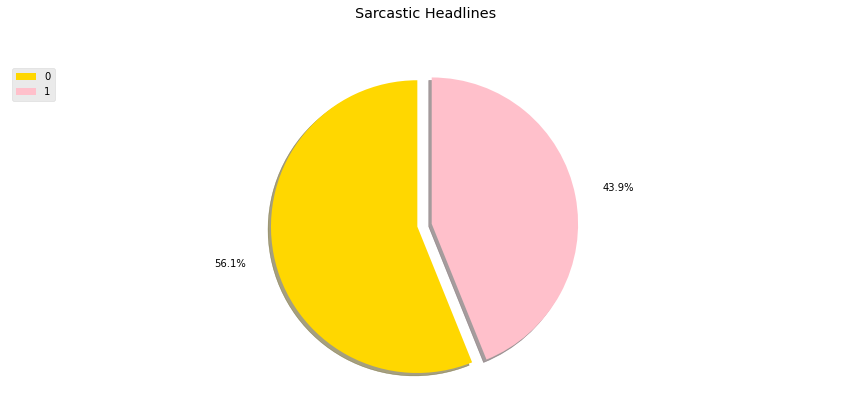

In [14]:
# draw a pie chart to look at the percentages

colors_list = ['gold', 'pink']
explode_list = [0, 0.1] # ratio for each continent with which to offset each wedge.

ax = df_types['total'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.3,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('Sarcastic Headlines', y=1.12) 
ax.get_yaxis().set_visible(False)
plt.axis('equal') 

# add legend
plt.legend(labels=df_types.index, loc='upper left') 

plt.show()

In [15]:
Q1 = sarcasm_df['headline_length'].quantile(0.25)

Q3 = sarcasm_df['headline_length'].quantile(0.75)

IQR = Q3 - Q1

min = Q1 - (1.5 * IQR)

max = Q3 + (1.5 * IQR)

In [16]:
print('max',max)
print('Q3',Q3)
print('Q1',Q1)
print('min',min)

max 110.5
Q3 73.0
Q1 48.0
min 10.5


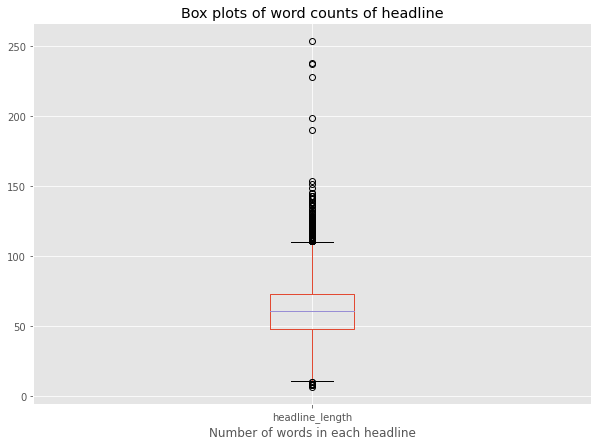

In [17]:
sarcasm_df['headline_length'].plot(kind='box', figsize=(10,7))
plt.title('Box plots of word counts of headline')
plt.xlabel('Number of words in each headline')
plt.show()

We can see outliers lie beyond maximum headline length of 110.5 and below minimum headline length of 10.5

In [18]:
below = len(sarcasm_df[sarcasm_df.headline_length < 10.5])
above = len(sarcasm_df[sarcasm_df.headline_length > 110.5])
print('Percentage of data that are outliers - ', ((below + above)/26709)*100)

Percentage of data that are outliers -  1.0146392601744731


Nothing much to worry about since only 1% of the data can cause some issue during model run

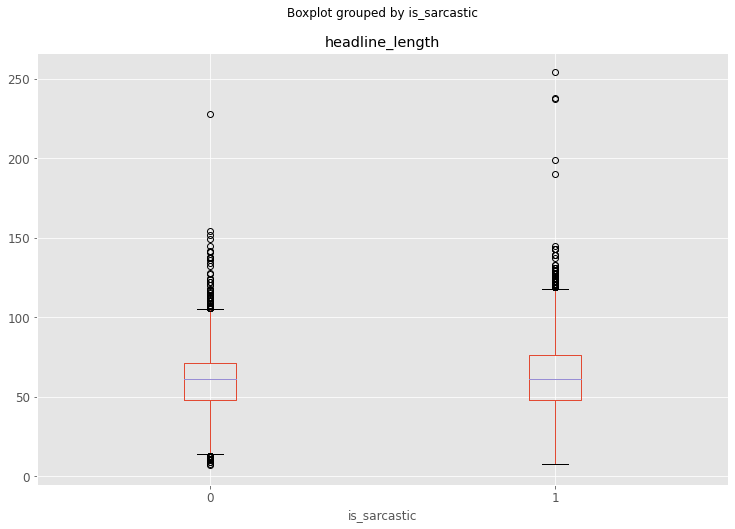

In [19]:
# to check for sarcastic and non-sarcastic types
boxplot = sarcasm_df.boxplot(column='headline_length', by='is_sarcastic', figsize=(12,8), fontsize='12')

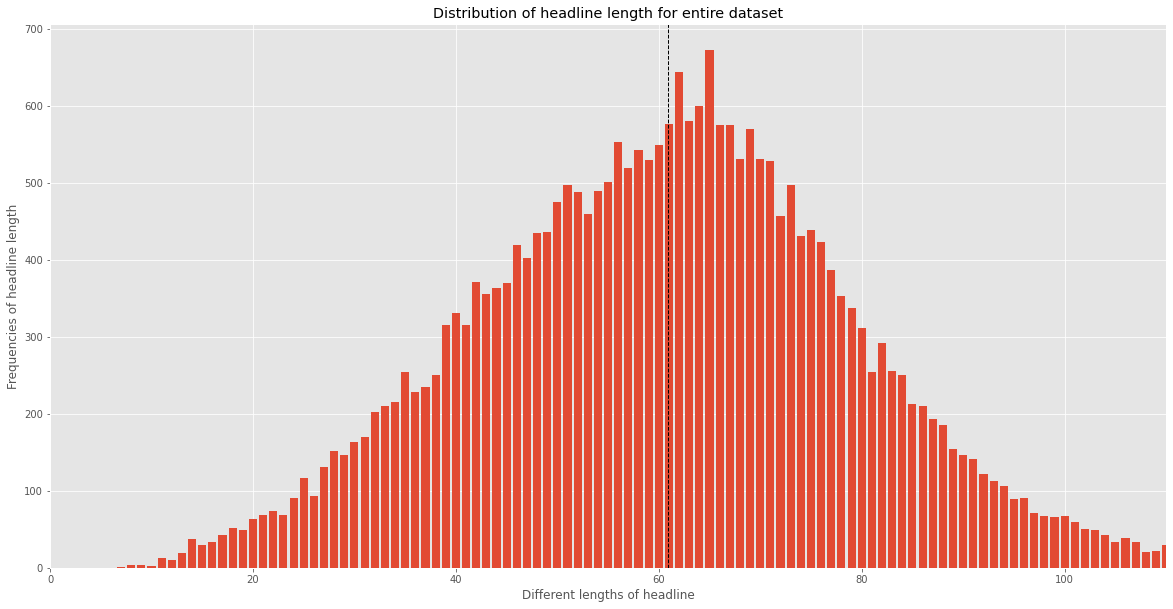

In [20]:
# To check distribution of headlines length

all_dat = sarcasm_df.groupby('headline_length').count()
sarcastic_dat1 = sarcasm_df[sarcasm_df.is_sarcastic==1]
sarcastic_dat = sarcastic_dat1.groupby('headline_length').count()
not_sarcastic_dat1 = sarcasm_df[sarcasm_df.is_sarcastic==0]
not_sarcastic_dat = not_sarcastic_dat1.groupby('headline_length').count()

# check distribution of headlines for entire dataset
plt.figure(figsize=(20,10))
plt.xlabel('Different lengths of headline')
plt.ylabel('Frequencies of headline length')
plt.title('Distribution of headline length for entire dataset')
plt.xlim([0,110])
plt.bar(all_dat.index, all_dat.headline)
plt.axvline(sarcasm_df.headline_length.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()

Looks like a normal distribution with slight skew to the left

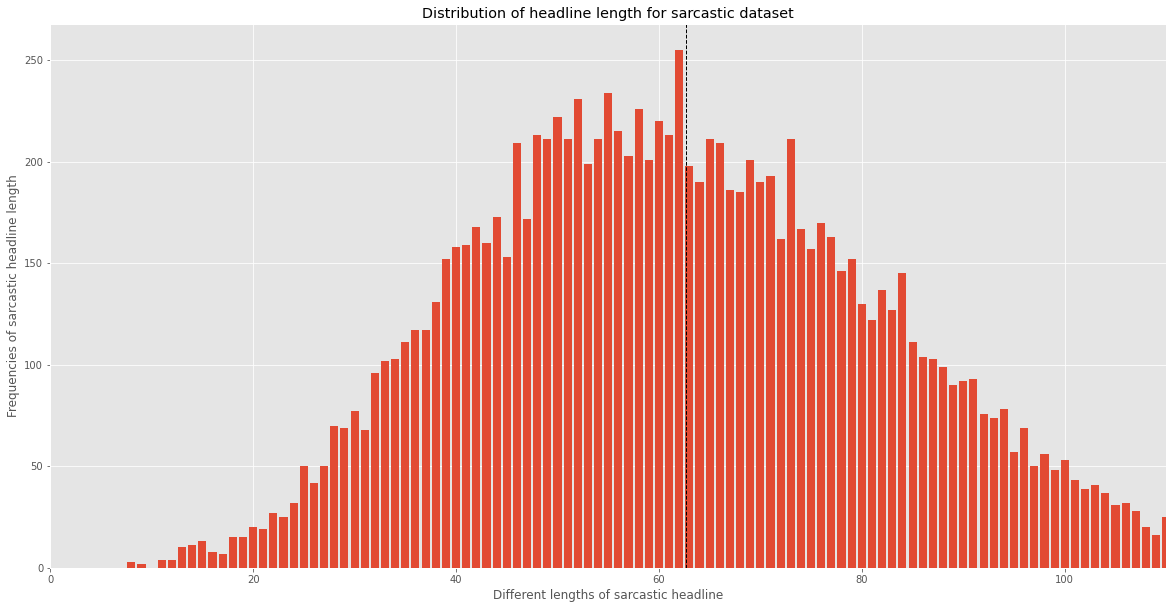

In [21]:

# check distribution of headline length for sarcastic dataset
plt.figure(figsize=(20,10))
plt.xlabel('Different lengths of sarcastic headline')
plt.ylabel('Frequencies of sarcastic headline length')
plt.title('Distribution of headline length for sarcastic dataset')
plt.xlim([0,110])
plt.bar(sarcastic_dat.index, sarcastic_dat.headline)
plt.axvline(sarcastic_dat1.headline_length.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()

Looks like a normal distribution with slight skew to the right

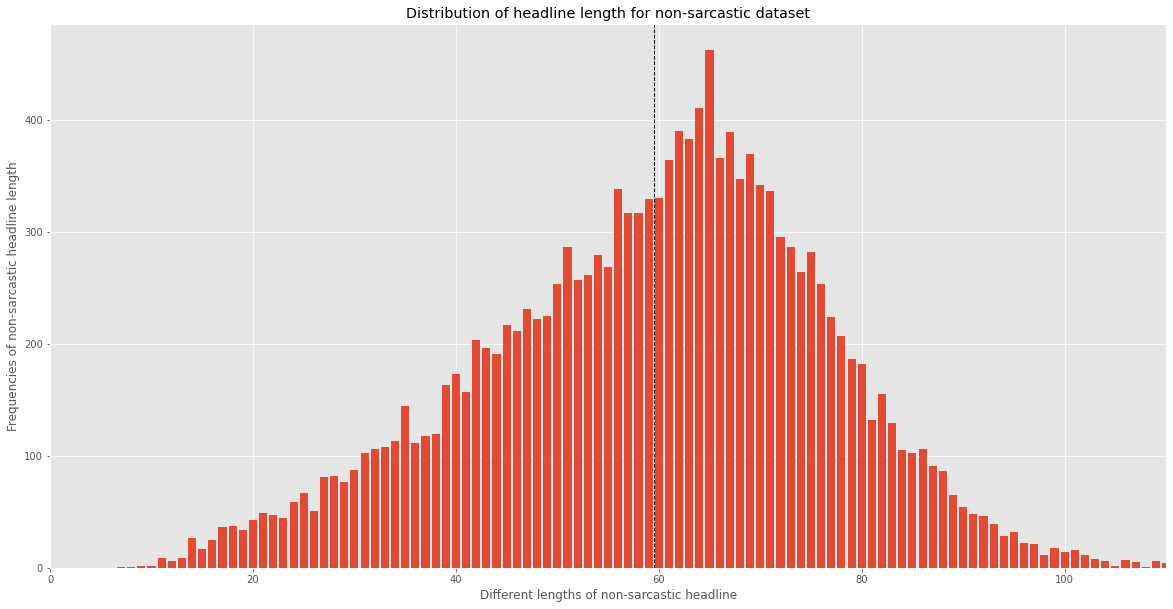

In [22]:
# check distribution of headline length for non-sarcastic dataset 
plt.figure(figsize=(20,10))
plt.xlabel('Different lengths of non-sarcastic headline')
plt.ylabel('Frequencies of non-sarcastic headline length')
plt.title('Distribution of headline length for non-sarcastic dataset')
plt.xlim([0,110])
plt.bar(not_sarcastic_dat.index, not_sarcastic_dat.headline)
plt.axvline(not_sarcastic_dat1.headline_length.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()

Looks like a normal distribution with moderate skewness to the left

### Lets build a **WordCloud**

In [23]:
# take a new dataframe with headline field in lower case and the sarcasm field
wc_df = sarcasm_df[['headline', 'is_sarcastic']]
wc_df['headline'] = wc_df['headline'].str.lower()
wc_df['headline'].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0          former versace store clerk sues over secret 'black code' for minority shoppers
1    the 'roseanne' revival catches up to our thorny political mood, for better and worse
2         mom starting to fear son's web series closest thing she will have to grandchild
3    boehner just wants wife to listen, not come up with alternative debt-reduction ideas
4                        j.k. rowling wishes snape happy birthday in the most magical way
Name: headline, dtype: object

In [24]:
#split the words into a list
all_words = wc_df['headline'].str.split(' ')
all_words.head()

0            [former, versace, store, clerk, sues, over, secret, 'black, code', for, minority, shoppers]
1    [the, 'roseanne', revival, catches, up, to, our, thorny, political, mood,, for, better, and, worse]
2         [mom, starting, to, fear, son's, web, series, closest, thing, she, will, have, to, grandchild]
3     [boehner, just, wants, wife, to, listen,, not, come, up, with, alternative, debt-reduction, ideas]
4                           [j.k., rowling, wishes, snape, happy, birthday, in, the, most, magical, way]
Name: headline, dtype: object

In [25]:
# data cleaning by removing punctuation
import string
all_headline_cleaned = []

for text in all_words:
    text = [x.strip(string.punctuation) for x in text]
    all_headline_cleaned.append(text)

# collect all the words of all the headlines as one text variable
text_headline = [" ".join(text) for text in all_headline_cleaned]
final_text_headline = " ".join(text_headline)
final_text_headline[:100]

'former versace store clerk sues over secret black code for minority shoppers the roseanne revival ca'

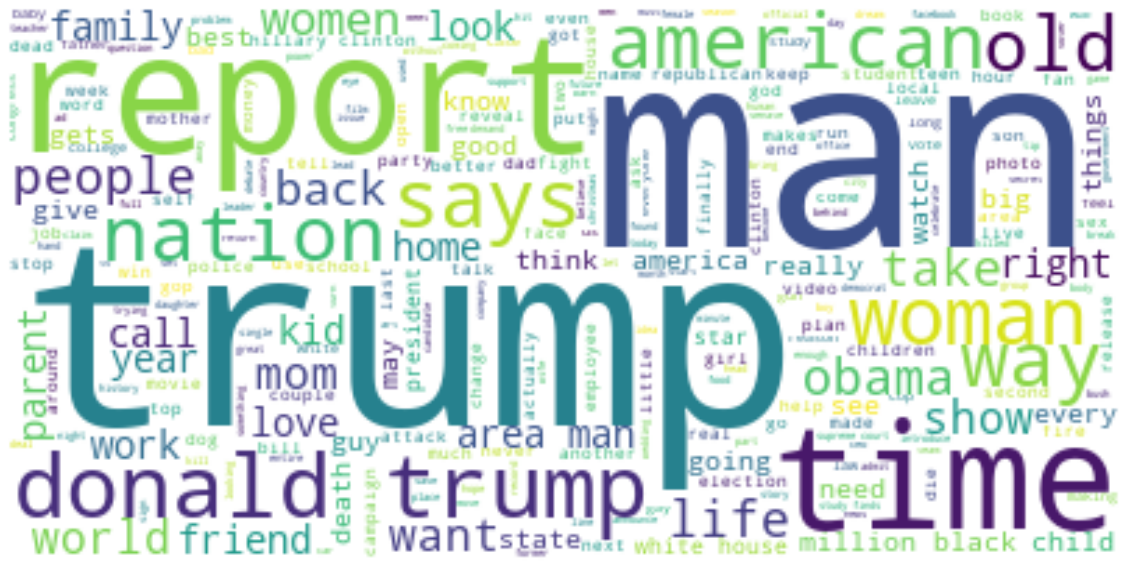

In [26]:
# worldcloud with 1000 frequent words
stopwords = set(STOPWORDS)
stopwords.update(["hi","will","still","thing","first","say","new","now","one","day","make","getting","find","year"])
wordcloud_headline = WordCloud(stopwords = stopwords, background_color="white", 
                           max_font_size=100, max_words=500).generate(final_text_headline)

plt.figure(figsize = (20,20))
plt.imshow(wordcloud_headline, interpolation='bilinear')
plt.axis("off")
plt.show()

### **Some Generic methods to plot metric curves**

In [27]:
# Generic method to plot the VALIDATION curves
def plot_validation_curve(history, metrics):
    plt.clf()
    history_dict = history.history
    f, ax = plt.subplots(1, len(metrics), figsize=(16,6))
    for i, metric in enumerate(metrics):
        metric_values = history_dict[metric]
        val_metric_values = history_dict['val_' + metric]
        epochs = range(1, (len(history_dict[metric]) + 1))
        ax[i].plot(epochs, metric_values, 'bo:', label='Training ' + metric)
        ax[i].plot(epochs, val_metric_values, 'go-', label='Validation ' + metric)
        ax[i].set_title('Training and Validation ' + ('Accuracy' if metric=='accuracy' else 'Loss'))
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Accuracy' if metric=='accuracy' else 'Loss')
        ax[i].legend()

In [28]:
# Generic method to plot Precision-Recall curve
def plot_prec_recall_vs_thresh(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend()

In [29]:
# Generic method to print the classification report
def classification_summary(y_test, y_pred, y_proba):
    print('\033[1mTesting accuracy:\033[0m %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('_'*80)
    print('\033[1mConfusion matrix:\033[0m\n %s' % (confusion_matrix(y_test, y_pred)))
    print('_'*80)
    print('\033[1mClassification report:\033[0m\n %s' % (classification_report(y_test, y_pred)))
    print('_'*80)
    print('\033[1mPrecision-Recall curve\033[10m')
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    plot_prec_recall_vs_thresh(precision, recall, thresholds)

In [30]:
# Generic method to plot ROC curve
def plot_roc(y_test, y_proba):
  y_probas = y_proba.reshape(y_proba.shape[0])
  fpr, tpr, threshold = roc_curve(y_test, y_probas)
  roc_auc = auc(fpr, tpr)
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

### Initialize parameter values
- Set values for max_features, maxlen, & embedding_size
- max_features: Number of words to take from tokenizer(most frequent words)
- maxlen: Maximum length of each sentence to be limited to 25
- embedding_size: size of embedding vector

In [31]:
max_features = 10000
maxlen = 25
embedding_size = 200

### Apply `tensorflow.keras` Tokenizer and get indices for words
- Initialize Tokenizer object with number of words as 10000
- Fit the tokenizer object on headline column
- Convert the text to sequence


In [ ]:
# def preprocessing(df):
#   data = df.copy(True)
#   data['headline'] = data['headline'].apply(lambda x: x.lower())
#   pattern = '[^a-zA-Z0-9\s]'
#   data['headline'] = data['headline'].apply((lambda x: re.sub(pattern,'',x)))
#   return data


In [32]:
# convert from text to tokens to sequences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(sarcasm_df.headline)
sequences = tokenizer.texts_to_sequences(sarcasm_df.headline)

In [33]:
print("The number of unique words in the text corpus dictionary : {}".format(len(tokenizer.word_index)))

The number of unique words in the text corpus dictionary : 29656


In [34]:
# check out the mapping of the text to the tokens
for i in (sarcasm_df['headline'][0]).split():
  print(i, tokenizer.word_index.get(i))

former 307
versace 15114
store 678
clerk 3336
sues 2297
over 47
secret 381
'black 2575
code' 15115
for 5
minority 2576
shoppers 8433


In [35]:
# since we took max featues as 10000, so all texts whose tokens are mapped to indexes higher than 10000 wont show up
# for example from above sentence, the two words 'versace' and ' code' ' are not present in below sequence
sequences[0]

[307, 678, 3336, 2297, 47, 381, 2575, 5, 2576, 8433]

### Pad sequences
- Pad each example with a maximum length
- Convert target column into numpy array

In [36]:
padded_sequence = pad_sequences(sequences,maxlen=maxlen,padding='post')

In [37]:
padded_sequence[10]

array([2924, 1679, 4720,   13,   36, 4274, 6971,    4, 2094, 1102,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [38]:
padded_sequence[0]

array([ 307,  678, 3336, 2297,   47,  381, 2575,    5, 2576, 8433,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

### Vocab mapping
- There is no word for 0th index

In [39]:
tokenizer.word_index

{'to': 1,
 'of': 2,
 'the': 3,
 'in': 4,
 'for': 5,
 'a': 6,
 'on': 7,
 'and': 8,
 'with': 9,
 'is': 10,
 'new': 11,
 'trump': 12,
 'man': 13,
 'from': 14,
 'at': 15,
 'about': 16,
 'you': 17,
 'this': 18,
 'by': 19,
 'after': 20,
 'up': 21,
 'out': 22,
 'be': 23,
 'how': 24,
 'as': 25,
 'it': 26,
 'that': 27,
 'not': 28,
 'are': 29,
 'your': 30,
 'his': 31,
 'what': 32,
 'he': 33,
 'all': 34,
 'just': 35,
 'who': 36,
 'has': 37,
 'will': 38,
 'more': 39,
 'one': 40,
 'into': 41,
 'report': 42,
 'year': 43,
 'why': 44,
 'have': 45,
 'area': 46,
 'over': 47,
 'donald': 48,
 'u': 49,
 'day': 50,
 'says': 51,
 's': 52,
 'can': 53,
 'first': 54,
 'woman': 55,
 'time': 56,
 'like': 57,
 'her': 58,
 "trump's": 59,
 'old': 60,
 'no': 61,
 'get': 62,
 'off': 63,
 'an': 64,
 'life': 65,
 'people': 66,
 'obama': 67,
 'now': 68,
 'house': 69,
 'still': 70,
 "'": 71,
 'women': 72,
 'make': 73,
 'was': 74,
 'than': 75,
 'white': 76,
 'back': 77,
 'my': 78,
 'i': 79,
 'clinton': 80,
 'down': 81,
 'i

### Set number of words
- Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [40]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

29657


### Load Glove Word Embeddings

In [ ]:
from zipfile import ZipFile
with ZipFile('/content/gdrive/My Drive/AIML_Colab/Datasets/SarcasmDetection/glove.6B.zip', 'r') as z:
  z.extractall()
#glove2word2vec('/content/gdrive/My Drive/AIML_Colab/Datasets/SarcasmDetection/glove.6B.200d.txt',
 #              'glove.6B.200d_txt.word2vec')
#model = KeyedVectors.load_word2vec_format('glove.6B.200d_txt.word2vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Create embedding matrix

In [41]:
EMBEDDING_FILE = '/content/gdrive/My Drive/AIML_Colab/Datasets/SarcasmDetection/glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

### Define model
- Hint: Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.

### Compile the model

### Fit the model

In [42]:
# splitting the data for train - validation - test
#y=to_categorical(sarcasm_df["is_sarcastic"].values)
y=sarcasm_df["is_sarcastic"]
X_train,X_test,y_train,y_test = train_test_split(padded_sequence,y,test_size=0.25)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(20031, 25) (20031,)
(6678, 25) (6678,)


In [43]:
print(y)

0        0
1        0
2        1
3        1
4        0
        ..
26704    0
26705    0
26706    0
26707    0
26708    0
Name: is_sarcastic, Length: 26709, dtype: int64


## Sorry, could not use hyperas as i kept getting error for which i did not find the resolution. Stupid hyperass.

In [ ]:
# notebook_source = 'Sarcasm Detection-Project 2_ Sequential Models in NLP _AIML_Aishik Sengupta'

In [ ]:
# def data():
#   vocab_size = 28400
#   max_features = 10000
#   maxlen = 25
#   embedding_size = 200

#   sarcasm_df = pd.read_json('/content/gdrive/My Drive/AIML/NLP/Sarcasm_Detection/Sarcasm_Detection_Data/Data/Sarcasm_Headlines_Dataset.json',lines=True)
#   data_df = sarcasm_df.copy(True)
#   data_df['headline'] = data_df['headline'].apply(lambda x: x.lower())
#   pattern = '[^a-zA-Z0-9\s]'
#   data_df['headline'] = data_df['headline'].apply((lambda x: re.sub(pattern,'',x)))
 
#   tokenizer = Tokenizer(num_words=10000,split=' ')
#   tokenizer.fit_on_texts(data_df['headline'].values)
#   sequences = tokenizer.texts_to_sequences(data_df['headline'].values)
#   after_padding_sequence = pad_sequences(sequences,maxlen=maxlen,padding='post',truncating='post')
#   y =  data_df.is_sarcastic.values

#   X_train,X_test,y_train,y_test = train_test_split(after_padding_sequence,y,test_size=0.2,random_state=42)

#   return X_train, y_train, X_test, y_test

# def create_model(X_train, y_train, X_test, y_test,):
#   vocab_size = 28400
#   max_features = 10000
#   maxlen = 25
#   embedding_size = 200

#   sarcasm_df = pd.read_json('/content/gdrive/My Drive/AIML/NLP/Sarcasm_Detection/Sarcasm_Detection_Data/Data/Sarcasm_Headlines_Dataset.json',lines=True)
#   data_df = sarcasm_df.copy(True)
#   data_df['headline'] = data_df['headline'].apply(lambda x: x.lower())
#   pattern = '[^a-zA-Z0-9\s]'
#   data_df['headline'] = data_df['headline'].apply((lambda x: re.sub(pattern,'',x)))
 
  
#   tokenizer = Tokenizer(num_words=10000,split=' ')
#   tokenizer.fit_on_texts(data_df['headline'].values)
#   sequences = tokenizer.texts_to_sequences(data_df['headline'].values)
#   after_padding_sequence = pad_sequences(sequences,maxlen=maxlen,padding='post',truncating='post')
#   y =  data_df.is_sarcastic.values

#   X_train,X_test,y_train,y_test = train_test_split(after_padding_sequence,y,test_size=0.2,random_state=42)
  
#   EMBEDDING_FILE =  '/content/gdrive/My Drive/AIML/NLP/Sarcasm_Detection/Sarcasm_Detection_Data/Data/glove.6B.200d.txt'
  
#   embeddings = {}
#   for o in open(EMBEDDING_FILE):
#       word = o.split(" ")[0]
#       print(word)
#       embd = o.split(" ")[1:]
#       embd = np.asarray(embd, dtype='float32')
#       print(embd)
#       embeddings[word] = embd

#   # create a weight matrix for words in training docs
#   embedding_matrix = np.zeros((vocab_size, 200))

#   for word, i in tokenizer.word_index.items():
#     embedding_vector = embeddings.get(word)
#     if embedding_vector is not None:
#       embedding_matrix[i] = embedding_vector

  # text_input = tf.keras.Input(shape=(max_len, ))
  # embed_text = tf.keras.layers.Embedding(vocab_size, 128)(text_input)

  # net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embed_text)
  # net = tf.keras.layers.GlobalMaxPool1D()(net)
  # net = tf.keras.layers.Dense(64, activation='relu')(net)
  # net = tf.keras.layers.Dropout(0.4)(net)
  # net = tf.keras.layers.Dense(32, activation='relu')(net)
  # net = tf.keras.layers.Dropout(0.4)(net)

  # output = tf.keras.layers.Dense(1, activation='sigmoid')(net)
  # model = tf.keras.models.Model(text_input, output)

  # model = Sequential()
  # model.add(Embedding(vocab_size,embedding_size,weights=[embedding_matrix],input_length=maxlen))
  # model.add(Bidirectional(LSTM({{choice([64,128,256,512])}},dropout={{uniform(0,1)}},return_sequences=True)))
  # model.add(GlobalMaxPool1D())
  # model.add(Dense({{choice([64,128,256,512])}}, activation='relu'))
  # model.add(Dropout({{uniform(0,1)}}))
  # model.add(Dense(32,activation='relu'))
  # model.add(Dropout({{uniform(0,1)}}))
  # model.add(Dense(1,activation='sigmoid'))

  # model.compile(optimizer= {{choice(['adam','rmsprop'])}},loss='binary_crossentropy',metrics=['accuracy'])

  # result = model.fit(X_train,y_train,
  #                   epochs={{choice([5,10,15,20])}},
  #                   batch_size={{choice([32,64,128])}},
  #                   verbose=2,
  #                   validation_split=0.2) 
  # validation_acc = np.max(result.history['val_accuracy'])
  # print('Best validation acc of epoch:', validation_acc)
  # return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [ ]:
# best_run, best_model = optim.minimize(model=create_model,
#                                       data = data,
#                                       algo=tpe.suggest,
#                                       max_evals=5,
#                                       trials=Trials(),
#                                       notebook_name = notebook_source
#                                       )
# X_train, y_train, X_test, y_test = data()
# print("Evalutation of best performing model:")
# print(best_model.evaluate(X_test, y_test))
# print("Best performing model chosen hyper-parameters:")
# print(best_run)

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import hyperas
except:
    pass

try:
    from google.colab import drive
except:
    pass

try:
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
except:
    pass

try:
    import collections
except:
    pass

try:
    from tensorflow.keras.preprocessing.text import Tokenizer
except:
    pass

try:
    import re
except:
    pass

try:
    from tensorflow.keras.preprocessing.sequence import pad_sequences
except:
    pass

try:
    from gensim.models import KeyedVectors
except:
    pass

try:
    from gensim.scripts.glove2word2vec import glove2word2vec
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from t

ValueError: ignored

In [ ]:
# X_train, y_train, X_test, y_test = data()
# print("Evalutation of best performing model:")
# print(best_model.evaluate(X_test, y_test))
# print("Best performing model chosen hyper-parameters:")
# print(best_run)

## **Final Model**

In [54]:
model=Sequential()
model.add(Embedding(num_words, embedding_size, input_length=maxlen, weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(100,return_sequences=True, dropout=0.2)))
model.add(Flatten())
model.add(Dense(50,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 200)           5931400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 25, 200)           240800    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                250050    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 6,422,301
Trainable params: 6,422,301
Non-trainable params: 0
____________________________________________

In [56]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [57]:
es = EarlyStopping(monitor='val_loss',min_delta=0.01,patience=3)
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max'
                            )

In [58]:
batch_size = 128
epochs = 10
result = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1,validation_split=0.2, callbacks=[es])

Epoch 1/10
126/126 [==============================] - 9s 70ms/step - loss: 0.4918 - accuracy: 0.7536 - val_loss: 0.3691 - val_accuracy: 0.8348
Epoch 2/10
126/126 [==============================] - 8s 64ms/step - loss: 0.2997 - accuracy: 0.8712 - val_loss: 0.3295 - val_accuracy: 0.8582
Epoch 3/10
126/126 [==============================] - 8s 64ms/step - loss: 0.2077 - accuracy: 0.9165 - val_loss: 0.3130 - val_accuracy: 0.8630
Epoch 4/10
126/126 [==============================] - 8s 64ms/step - loss: 0.1509 - accuracy: 0.9409 - val_loss: 0.3653 - val_accuracy: 0.8627
Epoch 5/10
126/126 [==============================] - 8s 64ms/step - loss: 0.1010 - accuracy: 0.9637 - val_loss: 0.4184 - val_accuracy: 0.8605
Epoch 6/10
126/126 [==============================] - 8s 65ms/step - loss: 0.0737 - accuracy: 0.9738 - val_loss: 0.5085 - val_accuracy: 0.8642


<Figure size 432x288 with 0 Axes>

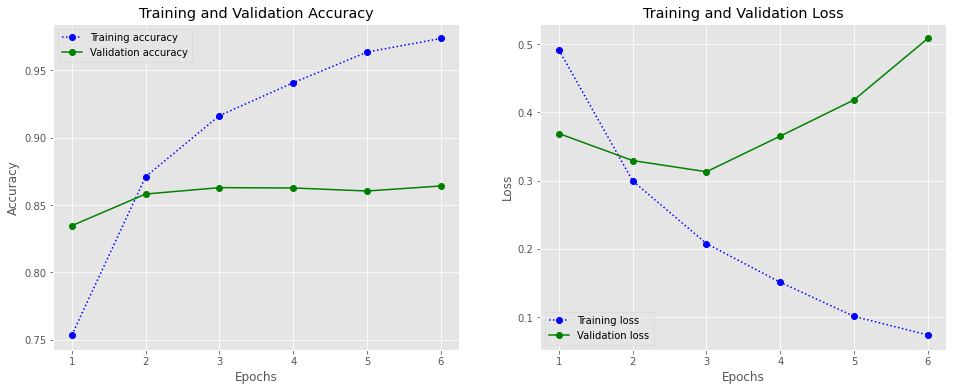

In [59]:
# VALIDATION ACCURACY and LOSS Curve
plot_validation_curve(result, ['accuracy','loss'])

In [60]:
# Find Loss and Accuracy of test set
loss, acc = model.evaluate(X_test, y_test)
print("Test Loss: %.4f and Accuracy: %.2f%%" % (loss, acc * 100))

209/209 [==============================] - 1s 4ms/step - loss: 0.5097 - accuracy: 0.8660
Test Loss: 0.5097 and Accuracy: 86.60%


In [61]:
y_pred = model.predict_classes(X_test)
y_proba = model.predict_proba(X_test)

In [62]:
print(y_test.shape)
print(y_pred.shape)
print(y_proba.shape)

(6678,)
(6678, 1)
(6678, 1)


Testing accuracy: 86.60%
________________________________________________________________________________
Confusion matrix:
 [[3294  439]
 [ 456 2489]]
________________________________________________________________________________
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      3733
           1       0.85      0.85      0.85      2945

    accuracy                           0.87      6678
   macro avg       0.86      0.86      0.86      6678
weighted avg       0.87      0.87      0.87      6678

________________________________________________________________________________
Precision-Recall curve


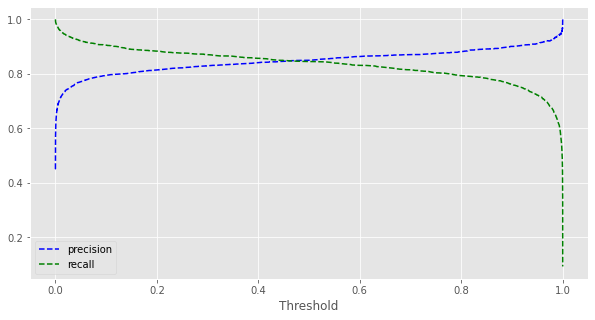

In [63]:
classification_summary(y_test, y_pred, y_proba)

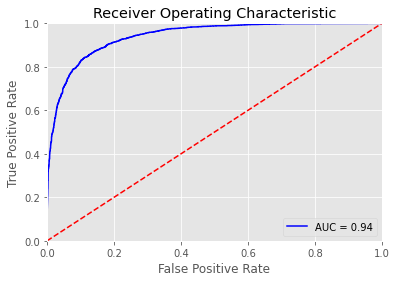

In [64]:
plot_roc(y_test, y_proba)

## **Prediction on a few samples**

In [65]:
sarcasm = {1: 'Sarcastic', 0: 'Not Sarcastic'}

In [67]:
y_test = y_test.values

In [68]:
headline_id = 100
prediction = model.predict_classes(pad_sequences([X_test[headline_id]], maxlen=maxlen))
print('Headline:', X_test[headline_id])
print('Prediction for Headline Number:',headline_id)
print('True News is', sarcasm.get(y_test[headline_id]))
print('Predicted News is', sarcasm.get(int(prediction[0][0])))

Headline: [1128  818    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
Prediction for Headline Number: 100
True News is Sarcastic
Predicted News is Sarcastic


In [69]:
headline_id = 200
prediction = model.predict_classes(pad_sequences([X_test[headline_id]], maxlen=maxlen))
print('Prediction for Headline Number:',headline_id)
print('True News is', sarcasm.get(y_test[headline_id]))
print('Predicted News is', sarcasm.get(int(prediction[0][0])))

Prediction for Headline Number: 200
True News is Sarcastic
Predicted News is Sarcastic


In [70]:
headline_id = 1000
prediction = model.predict_classes(pad_sequences([X_test[headline_id]], maxlen=maxlen))
print('Prediction for Headline Number:',headline_id)
print('True News is', sarcasm.get(y_test[headline_id]))
print('Predicted News is', sarcasm.get(int(prediction[0][0])))

Prediction for Headline Number: 1000
True News is Sarcastic
Predicted News is Sarcastic


In [71]:
headline_id = 2000
prediction = model.predict_classes(pad_sequences([X_test[headline_id]], maxlen=maxlen))
print('Prediction for Headline Number:',headline_id)
print('True News is', sarcasm.get(y_test[headline_id]))
print('Predicted News is', sarcasm.get(int(prediction[0][0])))

Prediction for Headline Number: 2000
True News is Not Sarcastic
Predicted News is Not Sarcastic


In [72]:
headline_id = 5000
prediction = model.predict_classes(pad_sequences([X_test[headline_id]], maxlen=maxlen))
print('Prediction for Headline Number:',headline_id)
print('True News is', sarcasm.get(y_test[headline_id]))
print('Predicted News is', sarcasm.get(int(prediction[0][0])))

Prediction for Headline Number: 5000
True News is Not Sarcastic
Predicted News is Not Sarcastic


In [73]:
headline_id = 4000
prediction = model.predict_classes(pad_sequences([X_test[headline_id]], maxlen=maxlen))
print('Prediction for Headline Number:',headline_id)
print('True News is', sarcasm.get(y_test[headline_id]))
print('Predicted News is', sarcasm.get(int(prediction[0][0])))

Prediction for Headline Number: 4000
True News is Sarcastic
Predicted News is Sarcastic


We would have been much happy if the model achieved validation and test accuracy of over 90%. But the accuracy is good enough for prediction.